In [1]:
from sklearn.datasets import load_diabetes, load_boston, fetch_california_housing, load_iris, load_breast_cancer
from sklearn.ensemble import RandomForestRegressor as RFR, RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

### Gradient Boosting

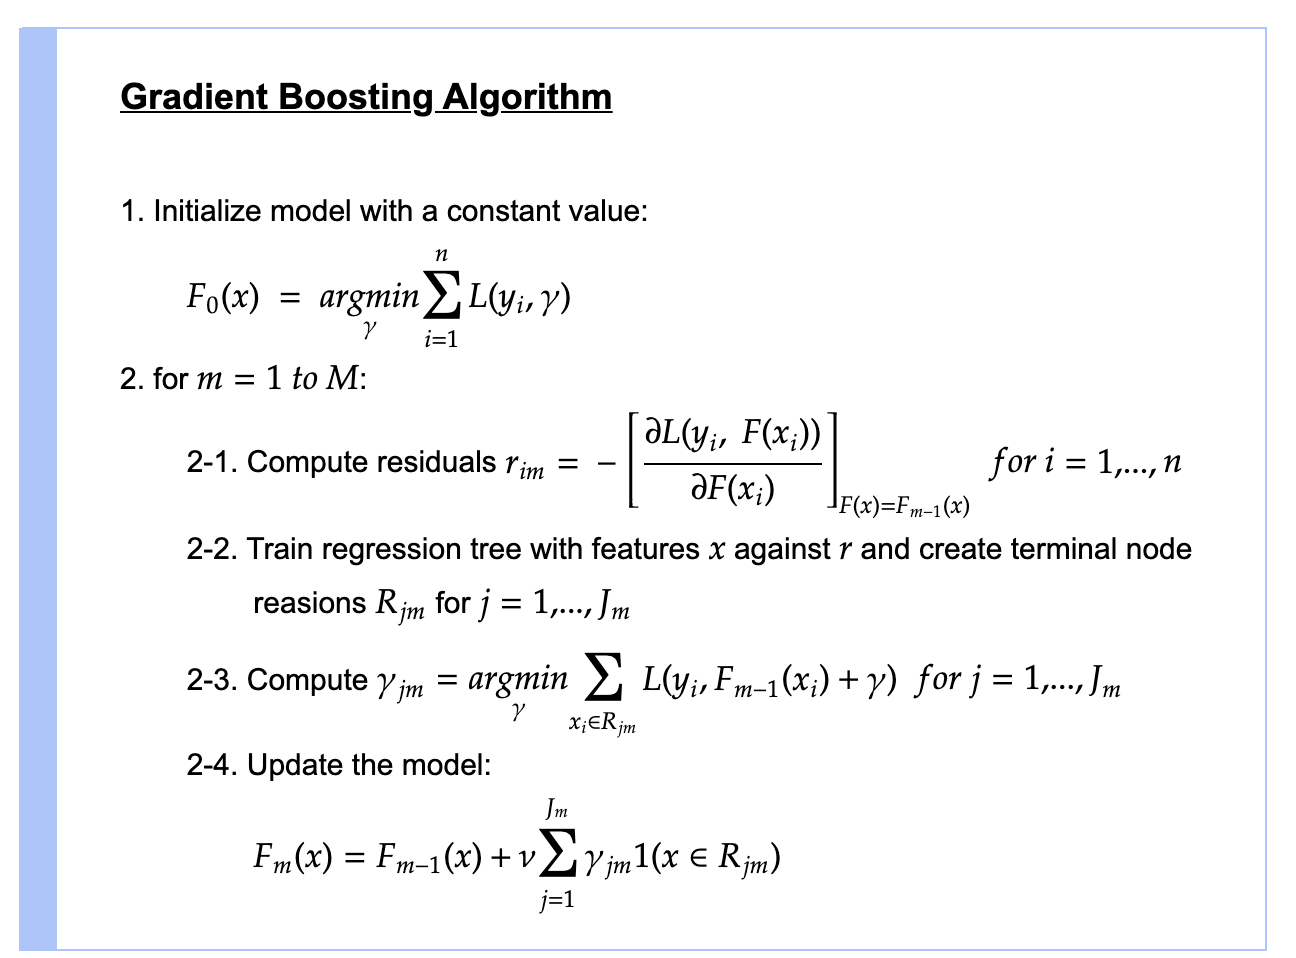

### Regression

\begin{aligned}
&\quad \frac{\mathrm{d}}{\mathrm{d} x}\left[-\frac{(y-x)^2}{2}\right] \\
&=-\frac{1}{2} \cdot \frac{\mathrm{d}}{\mathrm{d} x}\left[(y-x)^2\right] \\
&=-\frac{2(y-x) \cdot \frac{\mathrm{d}}{\mathrm{d} x}[y-x]}{2} \\
&=-(y-x)\left(\frac{\mathrm{d}}{\mathrm{d} x}[y]-\frac{\mathrm{d}}{\mathrm{d} x}[x]\right) \\
&=-(y-x)(0-1) \\
&=y-x
\end{aligned}

is the negative gradient aka pseudo residual

In [2]:
class L2Boosting(object):
    def __init__(self,n_rounds=100, lr=.1,
                 max_depth=3,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 stochastic = False,
                 subsample = .9,
                 rng=42):
        self.random_state = rng
        self.n_rounds = n_rounds
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.lr = lr
        self.stochastic = stochastic
        self.subsample = subsample
    def fit(self, X, y):
        self.models = []
        self.base   = np.mean(y)
        preds  = np.repeat(self.base, y.shape[0])
        resids = y - preds
        self.loss   = [ np.power(resids, 2).sum() ]
        
        for i in range(self.n_rounds):
            sample = np.random.choice(list(range(y.shape[0])), int(y.shape[0] * self.subsample), replace=False) if self.stochastic else list(range(y.shape[0]))
            self.models += [ DecisionTreeRegressor(random_state=self.random_state, max_depth=self.max_depth).fit(X[sample], resids[sample]) ]
            preds  = self.base + np.array([self.lr * model.predict(X) for model in self.models]).sum(axis=0) 
            resids = y - preds
            self.loss   += [ np.power(resids, 2).sum() ]
    
    def plot(self):
        return pd.Series(self.loss).plot(grid=True)

    def predict(self, X):
        return self.base + np.array([self.lr * model.predict(X) for model in self.models]).sum(axis=0) 

In [3]:
X, y = fetch_california_housing(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)

In [4]:
m0 = RFR(n_jobs=-1).fit(X_train, y_train)

<AxesSubplot: >

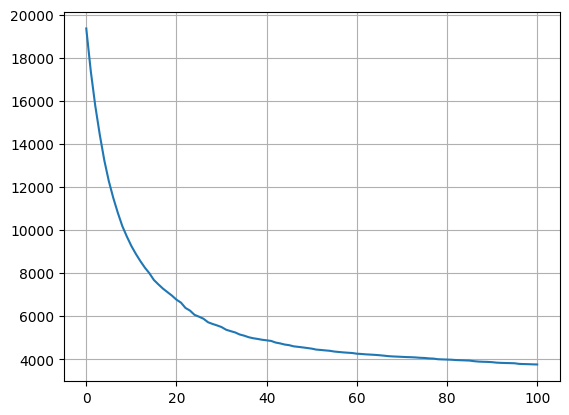

In [5]:
m = L2Boosting()
m.fit(X_train, y_train)
m.plot()

In [6]:
np.power(m0.predict(X_test) - y_test, 2).mean()

0.2554947694797313

In [7]:
np.power(m.predict(X_test) - y_test, 2).mean()

0.2883633786964563

### Classificaiton

$$\text{odds} = \frac{p}{1-p}$$

$$\text{log_odds} = \log(\frac{p}{1-p})$$

$$p = \text{odds} \times (1-p)$$

$$p = \frac{\exp(\text{log_odds})}{\exp(1 + \text{log_odds})}$$

$$p = \frac{\exp(\log(\frac{p}{1-p})}{\exp(1 + \log(\frac{p}{1-p}))}$$

$$
\sigma(x) =\frac{1}{1+e^{-x}}=\frac{e^x}{e^x+1}=\frac{1}{2}+\frac{1}{2} \tanh \left(\frac{x}{2}\right)
$$

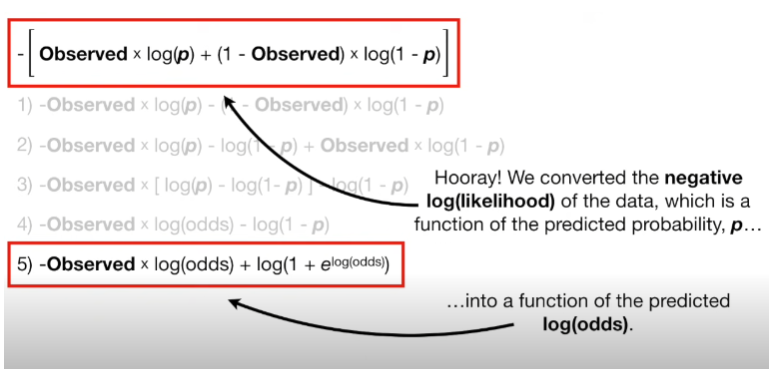

In [2]:
class NLLBoosting(object):
    def __init__(self,n_rounds=100, lr=.1,
                 max_depth=3,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 rng=42):
        self.random_state = rng
        self.n_rounds = n_rounds
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.lr = lr
        self.sigmoid = lambda log_odds : np.exp(log_odds)/(1+np.exp(log_odds))
    def fit(self, X, y):
        unique, counts = np.unique(y, return_counts=True)
        assert len(unique) == 2, "NLL not implemented as CE yet"
        q, p = counts / counts.sum()
        odds = p / q # i.e. p / (1-p) or simply counts[1] / counts[0] 
        log_odds = np.log(odds)

        self.models = []
        self.base   = log_odds
        preds  = np.repeat(p, counts.sum())
        self.loss   = [ -(y*np.log(preds)+(1-y)*np.log(1-preds)).mean() ] # i.e. avg cross entropy

        resids = y - preds

        for i in range(self.n_rounds):
            self.models += [ DecisionTreeRegressor(random_state=self.random_state,
                                                   max_depth=self.max_depth,
                                                   min_samples_split=self.min_samples_split,
                                                  min_samples_leaf=self.min_samples_leaf).fit(X, resids) ]
            log_odds  = self.base + np.array([self.lr * model.predict(X) for model in self.models]).sum(axis=0)
            preds = self.sigmoid(log_odds)
            resids = y - preds
            self.loss   += [ -(y*np.log(preds)+(1-y)*np.log(1-preds)).mean() ] 
    
    def plot(self):
        return pd.Series(self.loss).plot(grid=True)

    def predict(self, X):
        return self.sigmoid(self.base + np.array([self.lr * model.predict(X) for model in self.models]).sum(axis=0))

In [3]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.33, random_state=42
)

In [4]:
m0 = RFC().fit(X_train, y_train)
preds = m0.predict(X_test)
np.where(y_test == preds, 1, 0).mean()

0.9521276595744681

In [5]:
m = NLLBoosting()
m.fit(X_train, y_train)
preds = np.where(m.predict(X_test) > .5, 1, 0)
np.where(y_test == preds, 1, 0).mean()

0.9627659574468085

test on another dataset

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df["Sex"] = df["Sex"].apply(lambda x : {"male" : 1, "female" : 0}[x])
df = df[["Survived", 'Pclass', 'Sex', 'Age', 'SibSp']].dropna()
X = df[[ 'Pclass', 'Sex', 'Age', 'SibSp']].values
y = df["Survived"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
m0 = RFC().fit(X_train, y_train)
preds = m0.predict(X_test)
np.where(y_test == preds, 1, 0).mean()

0.7754237288135594

In [8]:
m = NLLBoosting()
m.fit(X_train, y_train)
preds = np.where(m.predict(X_test) > .5, 1, 0)
np.where(y_test == preds, 1, 0).mean()

0.7923728813559322

<AxesSubplot: >

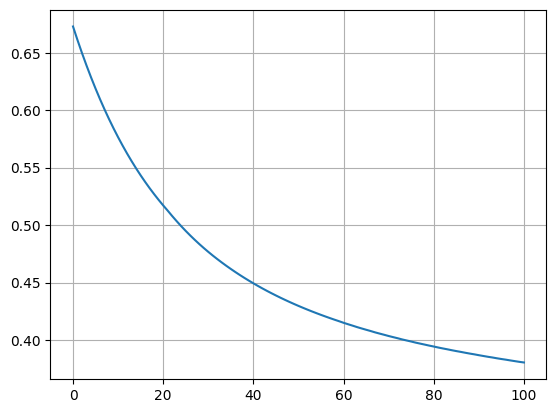

In [9]:
m.plot()

In [10]:
import graphviz
from sklearn import tree

In [12]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

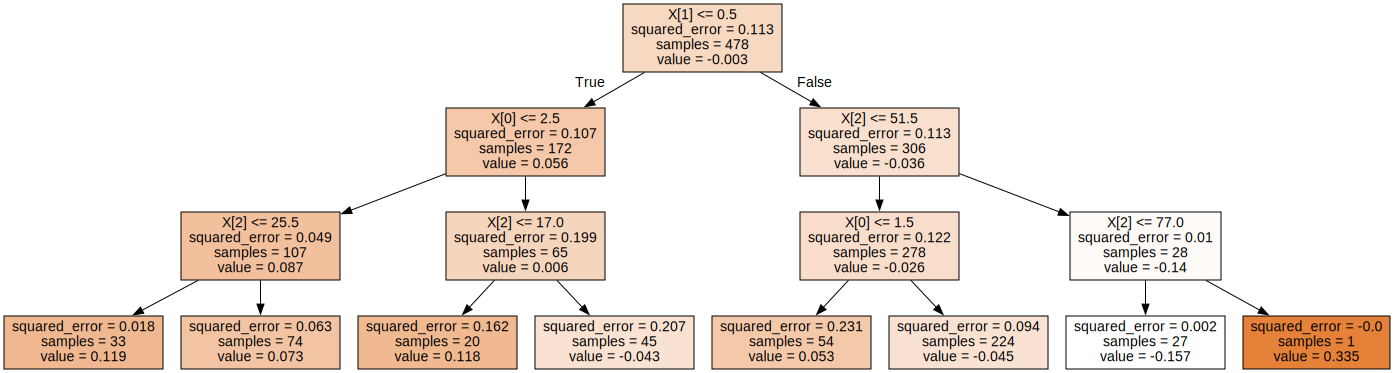

In [14]:
dot_data = tree.export_graphviz(m.models[-1], out_file=None,  
                                filled=True)
graphviz.Source(dot_data, format="png") 

In [ ]:
'C:/Program Files/Graphviz/bin/'